# Speed Comparisons between the Numpy an TF implementations of the DTCWT
Operations were performed on a system with a GTX 1080 GPU and Intel Xeon CPU E5-2660 CPU

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datasets
import dtcwt
import dtcwt.tf
import dtcwt_slim 
import tensorflow as tf
from tensorflow.python.client import timeline
from time import time
import numpy as np
import os
import py3nvml
plt.style.use('seaborn')
py3nvml.grab_gpus(1, gpu_fraction=0.95);

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Analysis of Small Images

## DTCWT on a single small image (64x64)

In [65]:
# Create the input
h, w = 64, 64
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd = dtcwt.Transform2d(biort='antonini', qshift='qshift_a')        # Numpy Transform
fwd_tf = dtcwt.tf.Transform2d(biort='antonini', qshift='qshift_a')  # Tensorflow Transform
fwd_slim = dtcwt_slim.Transform2d(biort='antonini', qshift='qshift_a') # Slim transform

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)
Yl, Yh = fwd_slim.forward(in_placeholder, nlevels=nlevels)
filter = tf.Variable(np.random.randn(10,10,1,1), dtype=tf.float32)
out_conv = tf.nn.conv2d(tf.expand_dims(in_placeholder, axis=1), filter, strides=[1,1,1,1],
                        padding='SAME', data_format='NCHW')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Implementations

In [54]:
small_np = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)
small_tf = %timeit -o sess.run([out_tf.lowpass_op, out_tf.highpasses_ops], {in_placeholder: in_})
small_slim = %timeit -o sess.run([Yl, Yh], {in_placeholder: in_})
small_conv = %timeit -o sess.run(out_conv, {in_placeholder: in_})

6.38 ms ± 47.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## DTCWT on a batch of small images (100x64x64)

In [59]:
in_ = np.random.randn(100,h,w)
small_np_batch = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)
small_tf_batch = %timeit -o sess.run([out_tf.lowpass_op, out_tf.highpasses_ops], {in_placeholder: in_})
small_slim_batch = %timeit -o sess.run([Yl, Yh], {in_placeholder: in_})
small_conv_batch = %timeit -o sess.run(out_conv, {in_placeholder: in_})

628 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Small Image Conclusion

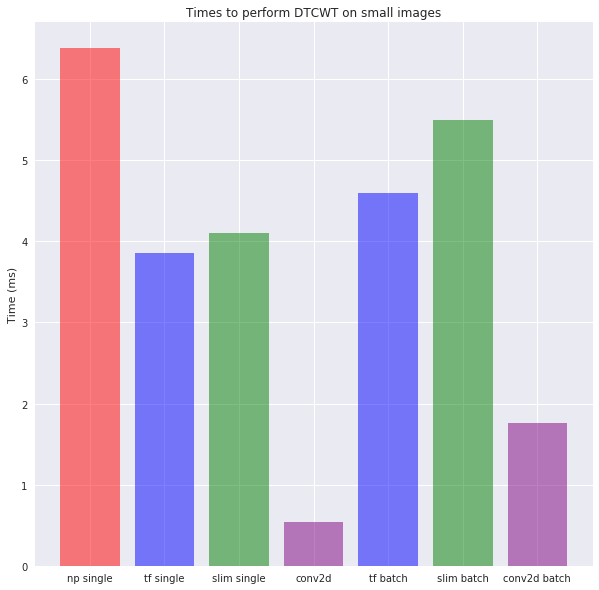

In [89]:
objects = ('np single', 'tf single', 'slim single', 'conv2d', 'tf batch', 'slim batch', 'conv2d batch')
y_pos = np.arange(len(objects))
performance = [small_np.average, small_tf.average, small_slim.average, small_conv.average,
               small_tf_batch.average, small_slim_batch.average, small_conv_batch.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(10,10))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue', 'green', 'purple', 'blue', 'green', 'purple'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform DTCWT on small images')
plt.show()

# Analysis of Large Images

## DTCWT on a single large image (512x512)

In [80]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd = dtcwt.Transform2d(biort='antonini', qshift='qshift_a')        # Numpy Transform
fwd_tf = dtcwt.tf.Transform2d(biort='antonini', qshift='qshift_a')  # Tensorflow Transform
fwd_slim = dtcwt_slim.Transform2d(biort='antonini', qshift='qshift_a')

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)
Yl, Yh = fwd_slim.forward(in_placeholder, nlevels=nlevels)
filter = tf.Variable(np.random.randn(10,10,1,1), dtype=tf.float32)
out_conv = tf.nn.conv2d(tf.expand_dims(in_placeholder, axis=1), filter, strides=[1,1,1,1],
                        padding='SAME', data_format='NCHW')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Compare Implementations

In [81]:
large_np = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)
large_tf = %timeit -o sess.run([out_tf.lowpass_op, out_tf.highpasses_ops], {in_placeholder: in_})
large_slim = %timeit -o sess.run([Yl, Yh], {in_placeholder: in_})
large_conv = %timeit -o sess.run(out_conv, {in_placeholder: in_})

66.7 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.23 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.12 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.33 ms ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## DTCWT on a batch of large images (100x512x512)
Batches are something tensorflow naturally handles. This should widen the gap as we only have to copy data to the GPU once for multiple images

In [82]:
in_ = np.random.randn(100,512,512)
large_np_batch = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)
large_tf_batch = %timeit -o sess.run([out_tf.lowpass_op, out_tf.highpasses_ops], {in_placeholder: in_})
large_slim_batch = %timeit -o sess.run([Yl, Yh], {in_placeholder: in_})
large_conv_batch = %timeit -o sess.run(out_conv, {in_placeholder: in_})

6.72 s ± 8.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
237 ms ± 8.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
262 ms ± 7.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
108 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Large Image Conclusion

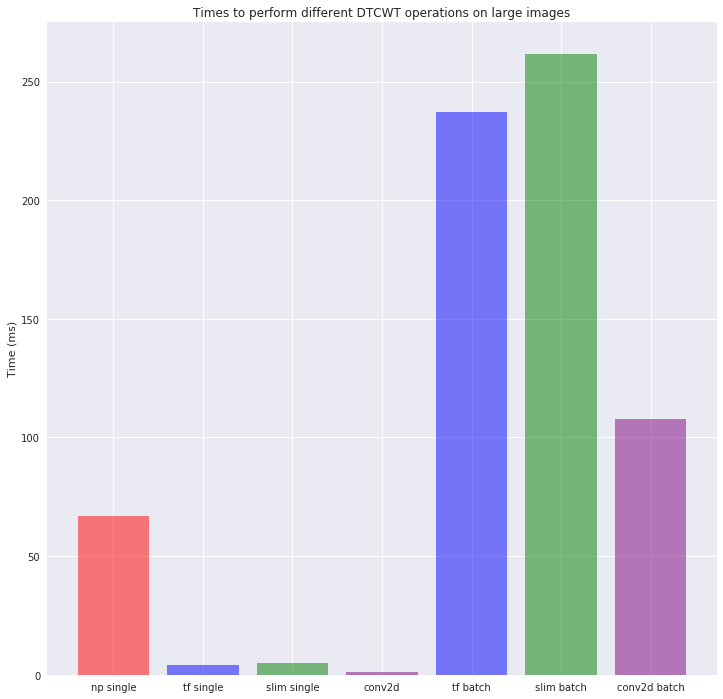

In [88]:
objects = ('np single', 'tf single', 'slim single', 'conv2d', 'tf batch', 'slim batch', 'conv2d batch')
y_pos = np.arange(len(objects))
performance = [large_np.average, large_tf.average, large_slim.average, large_conv.average,
               large_tf_batch.average, large_slim_batch.average,
               large_conv_batch.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(12,12))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue', 'green', 'purple', 'blue', 'green', 'purple'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform different DTCWT operations on large images')
plt.show()

# Multiple Channels

In [98]:
# Create the input
h, w = 256,256
in_ = np.random.randn(1,64,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd_tf = dtcwt.tf.Transform2d(biort='antonini', qshift='qshift_a')  # Tensorflow Transform
fwd_slim = dtcwt_slim.Transform2d(biort='antonini', qshift='qshift_a')

in_placeholder = tf.placeholder(tf.float32, [None, 64, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nchw', nlevels=nlevels)
Yl, Yh = fwd_slim.forward(in_placeholder, nlevels=nlevels)
filter = tf.Variable(np.random.randn(10,10,64,1), dtype=tf.float32)
out_conv = tf.nn.conv2d(in_placeholder, filter, strides=[1,1,1,1],
                        padding='SAME', data_format='NCHW')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [99]:
largech_tf = %timeit -o sess.run([out_tf.lowpass_op, out_tf.highpasses_ops], {in_placeholder: in_})
largech_slim = %timeit -o sess.run([Yl, Yh], {in_placeholder: in_})
largech_conv = %timeit -o sess.run(out_conv, {in_placeholder: in_})

34 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.9 ms ± 835 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.5 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### With a batch of images

In [100]:
in_ = np.random.randn(16,64,h,w)
largech_tf_batch = %timeit -o sess.run([out_tf.lowpass_op, out_tf.highpasses_ops], {in_placeholder: in_})
largech_slim_batch = %timeit -o sess.run([Yl, Yh], {in_placeholder: in_})
largech_conv_batch = %timeit -o sess.run(out_conv, {in_placeholder: in_})

569 ms ± 707 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
406 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
241 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


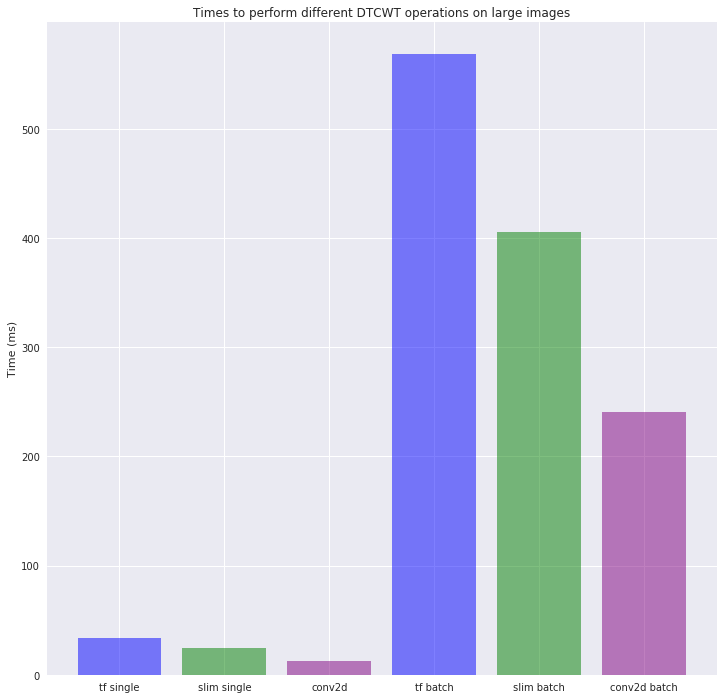

In [101]:
objects = ('tf single', 'slim single', 'conv2d', 'tf batch', 'slim batch', 'conv2d batch')
y_pos = np.arange(len(objects))
performance = [largech_tf.average, largech_slim.average, largech_conv.average,
               largech_tf_batch.average, largech_slim_batch.average,
               largech_conv_batch.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(12,12))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['blue', 'green', 'purple', 'blue', 'green', 'purple'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform different DTCWT operations on large images')
plt.show()

# Forward and Inverse together

In [103]:
# Create the input
h, w = 256, 256
in_ = np.random.randn(16,64,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd_tf = dtcwt.tf.Transform2d(biort='antonini', qshift='qshift_a')  # Tensorflow Transform
fwd_slim = dtcwt_slim.Transform2d(biort='antonini', qshift='qshift_a')

in_placeholder = tf.placeholder(tf.float32, [None, 64, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nchw', nlevels=nlevels)
out_tf = fwd_tf.inverse_channels(out_tf, data_format='nchw')

Yl, Yh = fwd_slim.forward(in_placeholder, nlevels=nlevels)
out_slim = fwd_slim.inverse(Yl, Yh)

filter = tf.Variable(np.random.randn(10,10,64,1), dtype=tf.float32)
out_conv = tf.nn.conv2d(in_placeholder, filter, strides=[1,1,1,1],
                        padding='SAME', data_format='NCHW')
filter = tf.Variable(np.random.randn(10,10,1,64), dtype=tf.float32)
out_conv = tf.nn.conv2d(out_conv, filter, strides=[1,1,1,1],
                        padding='SAME', data_format='NCHW')


sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [104]:
fwd_inv_tf = %timeit -o sess.run(out_tf, {in_placeholder: in_})
fwd_inv_slim = %timeit -o sess.run(out_slim, {in_placeholder: in_})
fwd_inv_conv = %timeit -o sess.run(out_conv, {in_placeholder: in_})

1.04 s ± 8.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
783 ms ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
263 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


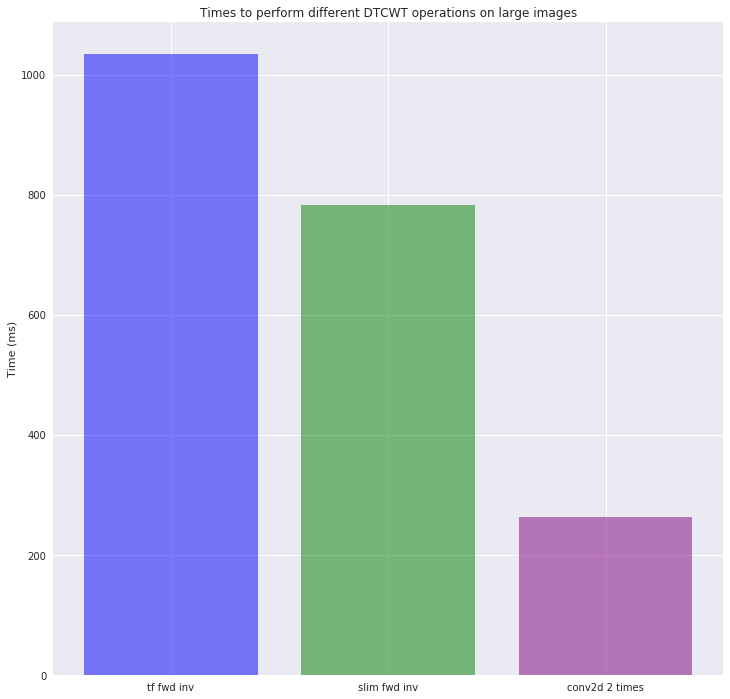

In [105]:
objects = ('tf fwd inv', 'slim fwd inv', 'conv2d 2 times')
y_pos = np.arange(len(objects))
performance = [fwd_inv_tf.average, fwd_inv_slim.average, fwd_inv_conv.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(12,12))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['blue', 'green', 'purple'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform different DTCWT operations on large images')
plt.show()